# Toxic comments classification

# EDA

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

Загружаем данные, с которыми будем работать

In [2]:
train_data = pd.read_csv('jigsaw-toxic-comment-classification-challenge/train.csv')
test_data = pd.read_csv('jigsaw-toxic-comment-classification-challenge/test.csv')
test_labels = pd.read_csv('jigsaw-toxic-comment-classification-challenge/test_labels.csv')

In [3]:
idx_to_drop = list(test_labels[test_labels.toxic == -1].index)
test_data = test_data.drop(idx_to_drop, axis=0).reset_index(drop=True)
test_labels = test_labels.drop(idx_to_drop, axis=0).reset_index(drop=True)

In [4]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Проверим датасет на наличие пустых значений

In [5]:
train_data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Отсюда можно понять, что большая часть наших комментариев "чистая" (т.е. не относится ни к какой из категорий)

In [7]:
lens = train_data.comment_text.str.len()
print('Mean: {}\n Std: {}\n Max: {}\n'.format(lens.mean(), lens.std(), lens.max()))

Mean: 394.0732213246768
 Std: 590.7202819048923
 Max: 5000



Видно, что в данных очень большой разброс в размере комментариев. Построим гистограмму распределения.

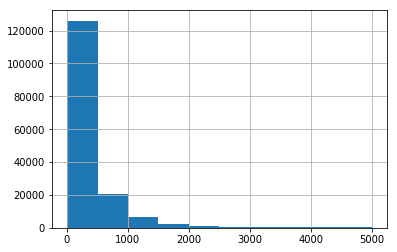

In [8]:
lens.hist()

In [9]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

Посмотрим на то, как наши 6 лейблов коррелируют друг с другом 

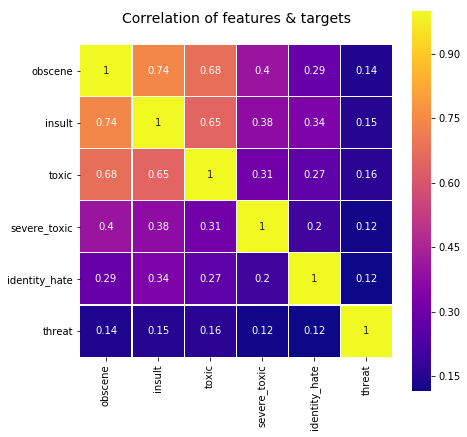

In [10]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(train_data[cols_target].astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

Заметно, что некоторые лейблы очень сильно коррелируют друг с другом (например, insult-obscene). Попытаемся это учесть в дальнейшем при построении модели.

Посмотрим на распределение комментарий в каждой из категорий 

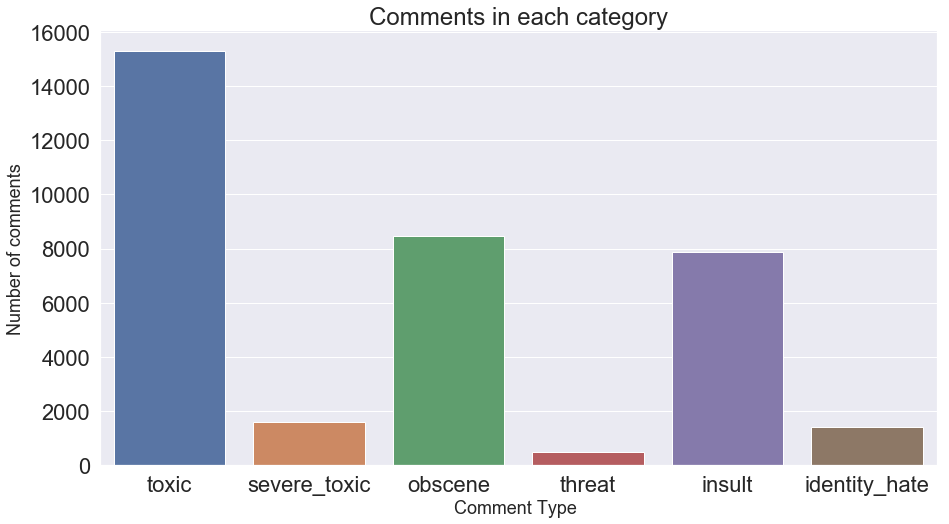

In [11]:
categories = list(train_data.columns.values)

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories[2:], train_data.iloc[:,2:].sum().values)
plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)
plt.show()

Можно сделать вывод, что выборка довольно несбалансированная 

Посмотрим, сколько комментариев относится к нескольким лейблам

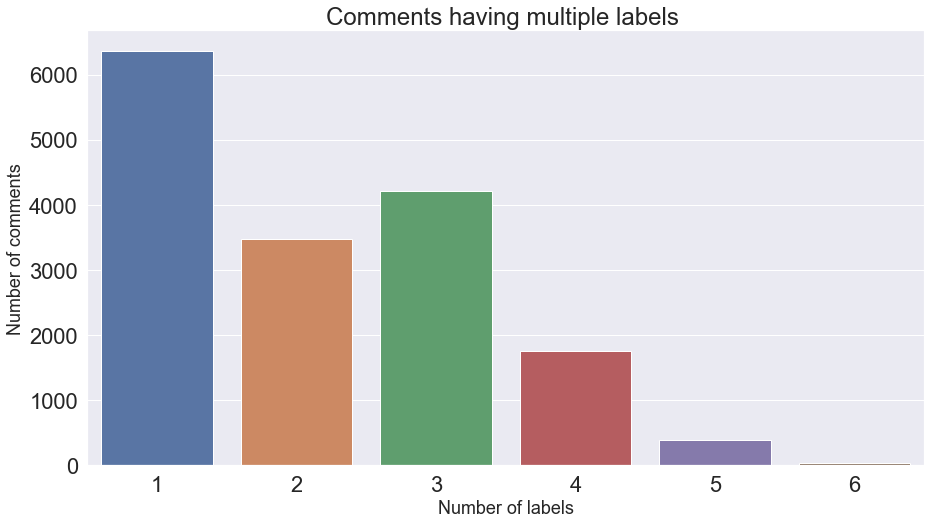

In [12]:
rowSums = train_data.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
plt.show()

# Препроцессинг данных

Проведем препроцессинг наших данных. Удалим из комментариев всю пунктуацию и прочие ненужные символы, удалим стоп-слова и проведем стемминг. Мы будем использовать именно стемминг, а не лемматизация, потому что она работает быстрее. Это именно то, что мы хотит при построении легковесной модели.

Все функции для препроцессинга реализованы в файле `utils.py`

In [13]:
from utils import *

In [14]:
data = {'train': train_data, 'test': test_data}

In [15]:
%%time

for key in data.keys():
    data[key]['comment_text'] = data[key]['comment_text'].str.lower()
    data[key]['comment_text'] = data[key]['comment_text'].apply(cleanPunc)
    data[key]['comment_text'] = data[key]['comment_text'].apply(keepAlpha)
    data[key]['comment_text'] = data[key]['comment_text'].apply(removeStopWords)
    data[key]['comment_text'] = data[key]['comment_text'].apply(stem)

CPU times: user 2min 42s, sys: 603 ms, total: 2min 43s
Wall time: 2min 44s


In [16]:
train, test = data['train'], data['test']
train_text = train['comment_text']
test_text = test['comment_text']

In [17]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww match background colour im seem stuck tha...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im realli tri edit war guy constant re...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggest improv wonder section s...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chanc rememb page that on,0,0,0,0,0,0


In [18]:
test.head()

,id,comment_text
0,0001ea8717f6de06,thank understand think high would revert witho...
1,000247e83dcc1211,dear god site horribl
2,0002f87b16116a7f,somebodi invari tri add religion realli mean w...
3,0003e1cccfd5a40a,say right type type institut need case three l...
4,00059ace3e3e9a53,ad new product list make sure relev ad new pro...


In [19]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,0,0,0,0,0,0
1,000247e83dcc1211,0,0,0,0,0,0
2,0002f87b16116a7f,0,0,0,0,0,0
3,0003e1cccfd5a40a,0,0,0,0,0,0
4,00059ace3e3e9a53,0,0,0,0,0,0


# Мультиклассовая классификация

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from scipy.sparse import csr_matrix, hstack

## OneVsRest Classifier with words n-grams

Сначала посмотрим на самую простейшую модель `OneVsRest Classifier`. Фактически она разбивает наш датасет на `n_labels` датасетов и отдельно для каждого учит бинарный классификатор (в нашем случае мы будем учить логистическую регрессию). Чтобы извлечь из наших комментариев признаки для обучения модели воспользуемся TF-IDF. 

In [21]:
%%time

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['id','comment_text'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test_labels.drop(labels = ['id'], axis=1)

classifier = OneVsRestClassifier(LogisticRegression(solver='sag'))

classifier.fit(x_train, y_train)
    
prediction = classifier.predict(x_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

Test accuracy is 0.9074056706993029
CPU times: user 1min 20s, sys: 1.9 s, total: 1min 22s
Wall time: 1min 24s


#### Мы получили довольно простую модель с очень хорошим скором. Главный недостаток этого метода, что он не учитывает корреляцию между лейблами. Попробуем учесть это, воспользовавшись следующей моделью.

## Classifier chains

Это модель работает так же как предыдущаю, но при обучении нового классификатора она учитываем результаты, которые мы получили при обучении предыдущего. Таким образом, мы сможем учесть взаимосвязь между лейблами.

Есть готовая реализация этого метода в библиотеке `scikit-multilearn`, однако по какой-то причине при запуске модели он ест слишком много памяти и ядро ноутбука каждый раз крашится. Я не смог найти решения этой проблемы, поэтому пришлось реализовать этот классификатор вручную.

In [22]:
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [24]:
%%time

x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['id','comment_text'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test_labels.drop(labels = ['id'], axis=1) 

prediction = np.zeros((test.shape[0], len(cols_target)))

classifier = LogisticRegression(solver='sag')

for i, label in enumerate(cols_target):
    print('... Processing {}'.format(label))
    y = y_train[label]
    classifier.fit(x_train,y)

    y_pred_X = classifier.predict(x_train)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)))
  
    test_y = classifier.predict(x_test)
    prediction[:, i] = test_y
    
    x_train = add_feature(x_train, y)
    print('Shape of x_train is now {}'.format(x_train.shape))
    
    x_test = add_feature(x_test, test_y)
    print('Shape of x_test is now {}'.format(x_test.shape))
    
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

... Processing obscene
Training Accuracy is 0.9798710291970345
Shape of x_train is now (159571, 1202955)
Shape of x_test is now (63978, 1202955)
... Processing insult
Training Accuracy is 0.9824028175545682
Shape of x_train is now (159571, 1202956)
Shape of x_test is now (63978, 1202956)
... Processing toxic
Training Accuracy is 0.9648244355177319
Shape of x_train is now (159571, 1202957)
Shape of x_test is now (63978, 1202957)
... Processing severe_toxic
Training Accuracy is 0.9915711501463298
Shape of x_train is now (159571, 1202958)
Shape of x_test is now (63978, 1202958)
... Processing identity_hate
Training Accuracy is 0.9937519975434133
Shape of x_train is now (159571, 1202959)
Shape of x_test is now (63978, 1202959)
... Processing threat
Training Accuracy is 0.9973491423880279
Shape of x_train is now (159571, 1202960)
Shape of x_test is now (63978, 1202960)
Test accuracy is 0.8990434211760293
CPU times: user 1min 3s, sys: 1.67 s, total: 1min 5s
Wall time: 1min 2s


#### Опять же получили довольно хороший скор, который тем не менее не сильно лучше результата нашей предыдущей модели. Попробуем теперь обучить классификатор "потяжелее".

##  OneVsRest Classifier with words and char n-grams

Сконструируем больше признаков, учитывая не только последовательности n-грам слов в комментариях, но и последовательности символов.

In [26]:
%%time
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)

char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

classifier = OneVsRestClassifier(LogisticRegression(solver='sag'))

classifier.fit(train_features, y_train)
    
prediction = classifier.predict(test_features)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

Test accuracy is 0.8919316014880115
CPU times: user 8min 9s, sys: 21.7 s, total: 8min 30s
Wall time: 8min 38s


#### Видим, что даже эта модель не сработала лучше, чем предыдущие, но вместе с тем она стала значительно тяжелее за счет увеличения признакового пространства.


## LSTM Neural Network

Попробуем проверить какую мы получим точность при обучении какой-нибудь "тяжелой" модели, которая может улавливать действительно сложные закономерности в данных.

Для обучения мы просто токкенизируем все наши комментарии и оставим от них лишь 200 слов (ведь, как мы убедились ранее, большая часть наших комментариев имеет не очень большую длину).

In [27]:
x_train = train['comment_text']
y_train = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
x_test = test['comment_text']
y_test = test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [28]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

Using TensorFlow backend.


In [29]:
x_tokenized_train = tokenizer.texts_to_sequences(x_train)
x_tokenized_test = tokenizer.texts_to_sequences(x_test)

In [30]:
from keras.preprocessing.sequence import pad_sequences

max_length = 300
X_train = pad_sequences(x_tokenized_train, maxlen=max_length)
X_test = pad_sequences(x_tokenized_test, maxlen=max_length)

#### Наша нейронная сеть будет состоять из следующих слоев:
* слой эмбеддинга слов 
* непосредственно LSTM слой
* слой для уменьшения размерности данных (GlobalAveragePooling1D)
* два fully-connected слоя с Dropout слоями перед ними (чтобы избежать переобучения)

#### Выходом сети будет 6 нейронов (вероятность принадлежности комментария к каждому из классов).


In [36]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GlobalAveragePooling1D, Dropout, Dense, LeakyReLU, Activation

num_features, embed_size = len(tokenizer.word_index), 128



model = Sequential()

model.add(Embedding(num_features + 1, embed_size, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.1))
model.add(Dense(48))
model.add(LeakyReLU())
model.add(Dropout(0.1))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
batch_size = 256
validation_split = 0.1
epochs = 3


print(model.summary())
model.fit(X_train, y_train,
                    validation_split=validation_split,
                    batch_size=batch_size,
                    epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 128)          17461504  
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 64)           49408     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)                3120      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 48)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48)                0         
__________

In [38]:
y_pred = model.predict(X_test, batch_size=16)

for i in range(y_pred.shape[0]):
    for j in range(y_pred.shape[1]):
        if y_pred[i,j] > 0.5:
            y_pred[i,j] = 1
        else:
            y_pred[i,j] = 0
            
print('Test accuracy is {}'.format(accuracy_score(y_test, y_pred)))

Test accuracy is 0.8970271030666792


Мы видим, что даже такая "тяжелая" модель как нейросеть не дает огромного буста в качестве предсказаний и даже проигрывает моделям, предложенным ранее.

 Таким образом, мы наблюдаем, что более комплексные модели не всегда дают большой буст в качестве. Иногда даже самые простые модели показывают очень хорошие результаты. Поэтому, выбирая лучшую в модель в отношении "скорость-качество", я бы выбрал самую первую и самую простую модель `OneVsRest Classifier with words n-grams`.